In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, sigma_z1, sigma_z2, enc_t=0, mot_t=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
    
    ndt = enc_t + mot_t
    return (rt+ndt)*ch, np.random.normal(enc_t, sigma_z1), np.random.normal(mot_t, sigma_z2)

In [3]:
def f(x, t, z, tau, delta, sigma=1):
    term1 = 1/np.sqrt(2 * np.pi * sigma**2 * (t-tau))
    term2 = -(x - z - delta * (t-tau))**2 / (2 * sigma**2 * (t-tau))
    return term1 * np.exp(term2)

def psi(b, db, t, z, tau, delta, sigma=1):
    term1 = 0.5*f(b(t), t, z, tau, delta, sigma)
    term2 = db(t) - delta - (b(t) - z - delta * (t-tau))/(t-tau)
    return term1 * term2

def fpt(ub, lb, dub, dlb, delta, z=0, sigma=1, dt=0.01, T_max=5):
    gu = [0]
    gl = [0]
    T = [0]
    
    gu.append(-2*psi(ub, dub, dt, z, 0, delta, sigma))
    gl.append( 2*psi(lb, dlb, dt, z, 0, delta, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        su = -2 * psi(ub, dub, n*dt, z, 0, delta, sigma)
        sl =  2 * psi(lb, dlb, n*dt, z, 0, delta, sigma)
        
        for j in range(1, n):
            if ub(j*dt) == 0:
                continue
            
            psi_n_j_pp = psi(ub, dub, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_pn = psi(ub, dub, n*dt, lb(j*dt), j*dt, delta, sigma)
            psi_n_j_np = psi(lb, dlb, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_nn = psi(lb, dlb, n*dt, lb(j*dt), j*dt, delta, sigma)
            
            su +=  2 * dt * (gu[j] * psi_n_j_pp + gl[j] * psi_n_j_pn)
            sl += -2 * dt * (gu[j] * psi_n_j_np + gl[j] * psi_n_j_nn)
            
        gu.append(su)
        gl.append(sl)
        T.append(n*dt)
        
    gu = np.asarray(gu)
    gl = np.asarray(gl)
    T = np.asarray(T)
    
    gtu = interp1d(T, gu)
    gtl = interp1d(T, gl)
    return gtu, gtl

In [4]:
def CDDM_likelihood(prms, RT, Z1, Z2):
    ub = lambda t: prms[0] /(1 + prms[1]*t)
    lb = lambda t: -1*ub(t)
    dub = lambda t: (-prms[1]*prms[0])/(1 + prms[1]*t)**2
    dlb = lambda t: -1*dub(t)

    delta = prms[2]
    sig = prms[3]
    t0 = prms[4]
    
    T_max = np.max(np.abs(RT))
    gtup, gtlp = fpt(ub, lb, dub, dlb, delta, z=0, dt=0.05, T_max=T_max)
#     gtun, gtln = fpt(ub, lb, dub, dlb, -delta, z=0, dt=0.05, T_max=T_max)
    
    ll = 0
    for i in range(len(RT)):
        if np.abs(RT[i])-t0 > 0:
            
            ll += 0.5*(Z1[i] + Z2[i] - t0)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2)
            
            if RT[i]>=0:                          
                if gtup(RT[i]-t0)>1e-14:
                    ll += -np.log(gtup(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14)
            else:                
                if gtlp(np.abs(RT[i])-t0)>1e-14:
                    ll += -np.log(gtlp(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14) 
        else:
            ll += -np.log(1e-14)
    
    return ll

In [5]:
recovery_dic = {'a_true': [],
                'a_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'delta_true': [],
                'delta_estimate': [],
                'sigma_true':[],
                'sigma_estimate':[],
                'ndt_true':[],
                'ndt_estimate':[]}

In [6]:
for n in tqdm(range(100)):
    threshold = np.random.uniform(1.5, 4)
    lamda = np.random.uniform(0.1, 2)
    delta = np.random.uniform(0, 3)
    sigma_z1 = np.random.uniform(0.05, 0.4)
    sigma_z2 = np.random.uniform(0.05, 0.4)
    enc_t = np.random.uniform(0.05, .6)
    mot_t = np.random.uniform(0.05, .6)
    
    ub = lambda t: threshold / (1 + lamda*t)
    lb = lambda t: -1*ub(t)
    
    RT = []
    Z1 = []
    Z2 = []
    
    for i in range(500):
        rt, z1, z2 = simulate_CDDM(ub, lb, delta, sigma_z1, sigma_z2, enc_t=enc_t, mot_t=mot_t)
        RT.append(rt)
        Z1.append(z1)
        Z2.append(z2)
        
    RT = np.array(RT)
    Z1 = np.array(Z1)
    Z2 = np.array(Z2)
    
    ans_cddm = differential_evolution(CDDM_likelihood,
                                      args=(RT, Z1, Z2), 
                                      bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                              (0.05, .6), (0.05, 1.2)])
    ans_cddm = minimize(CDDM_likelihood,
                        args=(RT, Z1, Z2),
                        method='Nelder-Mead',
                        x0=ans_cddm.x,
                        bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                (0.05, .6), (0.05, 1.2)])

    recovery_dic['a_true'].append(threshold)
    recovery_dic['a_estimate'].append(ans_cddm.x[0])
    recovery_dic['lambda_true'].append(lamda)
    recovery_dic['lambda_estimate'].append(ans_cddm.x[1])
    recovery_dic['delta_true'].append(delta)
    recovery_dic['delta_estimate'].append(ans_cddm.x[2])
    recovery_dic['sigma_true'].append(np.sqrt(sigma_z1**2 + sigma_z2**2))
    recovery_dic['sigma_estimate'].append(ans_cddm.x[3])
    recovery_dic['ndt_true'].append(enc_t + mot_t)
    recovery_dic['ndt_estimate'].append(ans_cddm.x[4])

100%|██████████████████████████████████████| 100/100 [3:29:14<00:00, 125.54s/it]


In [7]:
recovery_df = pd.DataFrame(recovery_dic)

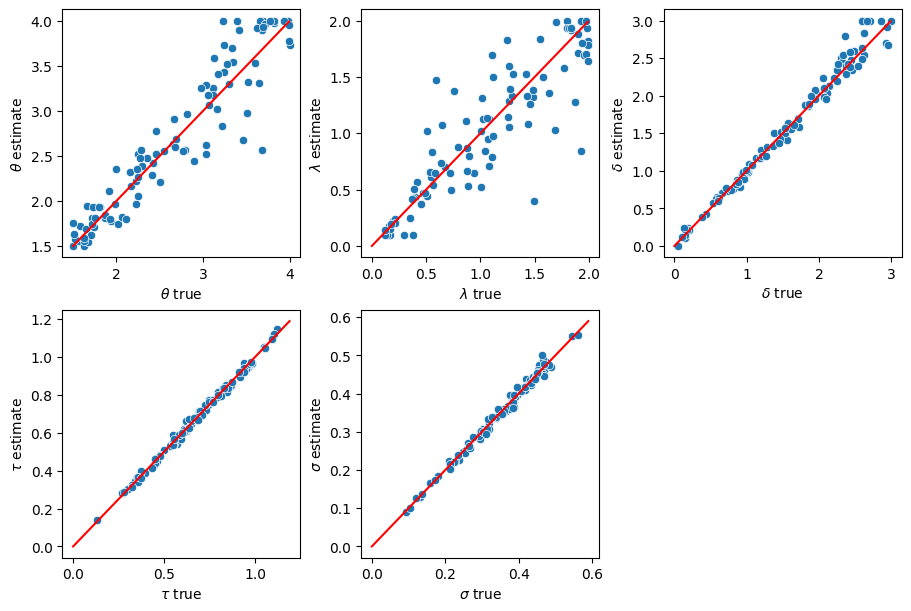

In [12]:
plt.figure(figsize=(9, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(1.5, 4, 0.01), np.arange(1.5, 4, 0.01), c='red')
sns.scatterplot(x='a_true', y='a_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
plt.xlabel(r'$\lambda$ true')
plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(0, 3, 0.01), np.arange(0, 3, 0.01), c='red')
sns.scatterplot(x='delta_true', y='delta_estimate', data=recovery_df);
plt.xlabel(r'$\delta$ true')
plt.ylabel(r'$\delta$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1.2, 0.01), np.arange(0, 1.2, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate')

plt.subplot(235)
plt.plot(np.arange(0, 0.6, 0.01), np.arange(0, .6, 0.01), c='red')
sns.scatterplot(x='sigma_true', y='sigma_estimate', data=recovery_df);
plt.xlabel(r'$\sigma$ true')
plt.ylabel(r'$\sigma$ estimate');

In [9]:
print(recovery_df.shape)
recovery_df.corr()

(100, 10)


,a_true,a_estimate,lambda_true,lambda_estimate,delta_true,delta_estimate,sigma_true,sigma_estimate,ndt_true,ndt_estimate
a_true,1.000000,0.943115,-0.080371,-0.129129,0.079453,0.104747,-0.095863,-0.091801,-0.011036,-0.014622
a_estimate,0.943115,1.000000,-0.126772,-0.045775,0.094919,0.102771,-0.207682,-0.198575,-0.037563,-0.053370
lambda_true,-0.080371,-0.126772,1.000000,0.887511,-0.075884,-0.065048,-0.025496,-0.026138,-0.104662,-0.094892
lambda_estimate,-0.129129,-0.045775,0.887511,1.000000,-0.059291,-0.088887,-0.161872,-0.158799,-0.110365,-0.111516
delta_true,0.079453,0.094919,-0.075884,-0.059291,1.000000,0.991240,0.094580,0.094390,0.159343,0.156884
delta_estimate,0.104747,0.102771,-0.065048,-0.088887,0.991240,1.000000,0.097005,0.096611,0.167344,0.165068
sigma_true,-0.095863,-0.207682,-0.025496,-0.161872,0.094580,0.097005,1.000000,0.995250,0.228001,0.240430
sigma_estimate,-0.091801,-0.198575,-0.026138,-0.158799,0.094390,0.096611,0.995250,1.000000,0.204592,0.216760
ndt_true,-0.011036,-0.037563,-0.104662,-0.110365,0.159343,0.167344,0.228001,0.204592,1.000000,0.997759
ndt_estimate,-0.014622,-0.053370,-0.094892,-0.111516,0.156884,0.165068,0.240430,0.216760,0.997759,1.000000


In [10]:
recovery_df.to_csv('Hyperbolic_rec.csv')